In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from generate_ellipses import get_ellipses_dataset, get_disk_dist_ellipses_dataset
from Model_arch_reg import Net
import deepinv as dinv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/ktaghavi/miniconda3/envs/msc_dip_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ellipses_train = get_ellipses_dataset(fold="train", im_size = 256, length = 5000, max_n_ellipse = 70)
# ellipses_val = get_ellipses_dataset(fold="val", im_size = 256, length = 1000, max_n_ellipse = 70)
disk_train = get_disk_dist_ellipses_dataset(fold="train", im_size = 256, length = 5000, max_n_ellipse = 70)
disk_val = get_disk_dist_ellipses_dataset(fold="val", im_size = 256, length = 1000, max_n_ellipse = 70)


(-0.5, 255.5, 255.5, -0.5)

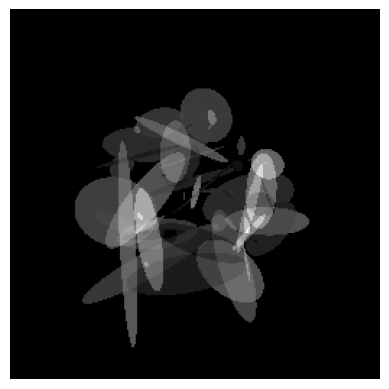

In [3]:
ellipses_test = disk_train[0][0].squeeze(0).numpy()

plt.imshow(ellipses_test, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

In [4]:
ds_data_train = DataLoader(disk_train, batch_size=16)
ds_data_val = DataLoader(disk_val, batch_size=16)

In [5]:
model = Net(256, 1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
angles_torch = torch.linspace(0,180,60,device=device)
physics_raw = dinv.physics.Tomography(
        img_width=256, 
        angles=angles_torch, 
        device=device,
        noise_model=dinv.physics.GaussianNoise(sigma=0.2),
    )

In [7]:
os.makedirs('checkpoints', exist_ok=True)
best_test_loss = float('inf')

epochs = 10
for epoch in range(epochs):
    model.train()
    running_train = 0.0
    for real_img in ds_data_train:
        real_img = real_img.to(device)

        # 1) Forward + forward backproj → fake images
        with torch.no_grad():
            sinogram= physics_raw(real_img)
            # sinogram  = physics_raw.A(real_img)
            noise_img = physics_raw.A_dagger(sinogram)
            img_np = real_img[0][0].squeeze().detach().cpu().numpy()
            noise_img_np = noise_img[0][0].squeeze().detach().cpu().numpy()
            # plt.imshow(img_np, cmap='gray')
            # plt.title('Real Image')
            # plt.axis('off')
            # plt.show()
            # plt.imshow(noise_img_np, cmap='gray')
            # plt.title('Noisy Image')
            # plt.axis('off')
            # plt.show()
            # img_np = sinogram_physics[0][0].squeeze().detach().cpu().numpy()
            # noise_img_np = noise_img[0][0].squeeze().detach().cpu().numpy()
            # plt.imshow(img_np, cmap='gray')
            # plt.title('Physics Sinogram')
            # plt.axis('off')
            # plt.show()

        # 2) Critic scores
        D_real = model(real_img).mean()
        D_fake = model(noise_img).mean()

        # 3) Wasserstein term
        L_wass = D_real - D_fake

        # 4) Gradient penalty
        alpha    = torch.rand(real_img.size(0),1,1,1, device=device)
        interp   = (alpha * real_img + (1 - alpha) * noise_img).requires_grad_(True)
        
        D_interp = model(interp)
        grads    = torch.autograd.grad(outputs=D_interp.sum(),
                                    inputs=interp,
                                    create_graph=True)[0]
        grad_norm= grads.view(grads.size(0), -1).norm(2, dim=1)
        L_gp     = ((grad_norm - 1)**2).mean()

        # 5) Critic update
        lambda_gp = 10.0
        loss = L_wass + lambda_gp * L_gp
        opt.zero_grad()
        loss.backward()
        opt.step()

        running_train += loss.item() * real_img.size(0)

    print(f"Epoch {epoch:02d} train Loss: {running_train/len(ds_data_train):.4f}")
    print(f"D_real = {D_real.item():.4f}, D_fake = {D_fake.item():.4f}")

    running_test = 0.0
    n_batches = 0
    model.eval()
    with torch.no_grad():
        for real_img in ds_data_val:
            n_batches += 1
            real_img = real_img.to(device)
            sinogram = physics_raw(real_img)
            noise_img = physics_raw.A_dagger(sinogram)
            D_real = model(real_img).mean()
            D_noise = model(noise_img).mean()

            L_wass = D_real - D_noise 
            alpha = torch.rand(real_img.size(0),1,1,1, device=device)
            intrep = (alpha * real_img + (1 - alpha) * noise_img).requires_grad_(True)

            with torch.enable_grad():
                D_intrep = model(intrep)
                grad_intrep = torch.autograd.grad(
                outputs=D_intrep.sum(), inputs=intrep,
                create_graph=True
                )[0]
        
            grad_norm = grad_intrep.view(grad_intrep.size(0), -1).norm(2, dim=1)
            L_gp = ((grad_norm - 1)**2).mean()
            lambda_gp = 10.0
            
            loss = L_wass + lambda_gp * L_gp
            running_test += loss.item()
    avg_loss = running_test / n_batches
    if avg_loss < best_test_loss:
        best_test_loss = avg_loss
        torch.save(model.state_dict(), 'checkpoints/pre_model_reg_FBP_low.pth')
        print(f"Best model saved at epoch {epoch}")

    print(f"Epoch {epoch:02d} test Loss: {avg_loss:.4f}")
    print(f"D_real = {D_real.item():.4f}, D_fake = {D_noise.item():.4f}")

Epoch 00 train Loss: -26.2556
D_real = -33.0178, D_fake = -23.1772
Best model saved at epoch 0
Epoch 00 test Loss: -8.1311
D_real = -32.6683, D_fake = -23.5283
Epoch 01 train Loss: -138.2948
D_real = -38.6065, D_fake = -27.5522
Best model saved at epoch 1
Epoch 01 test Loss: -9.1528
D_real = -38.1991, D_fake = -27.7693
Epoch 02 train Loss: -148.3525
D_real = -40.7080, D_fake = -28.9133
Best model saved at epoch 2
Epoch 02 test Loss: -9.4760
D_real = -39.9183, D_fake = -28.6367
Epoch 03 train Loss: -151.4460
D_real = -57.4767, D_fake = -45.6934
Best model saved at epoch 3
Epoch 03 test Loss: -9.5909
D_real = -57.3455, D_fake = -46.1462
Epoch 04 train Loss: -153.3127
D_real = -69.9084, D_fake = -58.3240
Best model saved at epoch 4
Epoch 04 test Loss: -9.7242
D_real = -69.8927, D_fake = -58.8039
Epoch 05 train Loss: -154.5939
D_real = -70.7958, D_fake = -59.0353
Best model saved at epoch 5
Epoch 05 test Loss: -9.7857
D_real = -70.7277, D_fake = -59.5604
Epoch 06 train Loss: -155.8936
D_re

In [8]:
model_bp = Net(256, 1).to(device)
opt = torch.optim.Adam(model_bp.parameters(), lr=1e-4)

In [9]:
ds_data_train_bp = DataLoader(disk_train, batch_size=16)
ds_data_val_bp = DataLoader(disk_train, batch_size=16)

In [10]:
os.makedirs('checkpoints', exist_ok=True)
best_test_loss = float('inf')

epochs = 10
for epoch in range(epochs):
    model_bp.train()
    running_train = 0.0
    for real_img in ds_data_train_bp:
        real_img = real_img.to(device)
        # real_img = real_img.unsqueeze(1) 
        # 1) Forward + backproj → fake images
        with torch.no_grad():
            sinogram  = physics_raw(real_img)
            noise_img = physics_raw.A_adjoint(sinogram)
            # Normalize and clamp the noise image
            # This is important to ensure the noise image is in the same range as the real image
            noise_img = (noise_img - noise_img.mean())/(noise_img.std() + 1e-8)
            noise_img = torch.clamp(noise_img, 0, 1)
            
            img_np = real_img[0][0].squeeze().detach().cpu().numpy()
            noise_img_np = noise_img[0][0].squeeze().detach().cpu().numpy()
            # plt.imshow(img_np, cmap='gray')
            # plt.title('Real Image')
            # plt.axis('off')
            # plt.show()
            # plt.imshow(noise_img_np, cmap='gray')
            # plt.title('Noisy Image')
            # plt.axis('off')
            # plt.show()


        # 2) Critic scores
        D_real = model_bp(real_img).mean()
        D_fake = model_bp(noise_img).mean()

        # 3) Wasserstein term
        L_wass = D_real - D_fake

        # 4) Gradient penalty
        alpha    = torch.rand(real_img.size(0),1,1,1, device=device)
        interp   = (alpha * real_img + (1 - alpha) * noise_img).requires_grad_(True)
        
        D_interp = model_bp(interp)
        grads    = torch.autograd.grad(outputs=D_interp.sum(),
                                    inputs=interp,
                                    create_graph=True)[0]
        grad_norm= grads.view(grads.size(0), -1).norm(2, dim=1)
        L_gp     = ((grad_norm - 1)**2).mean()

        # 5) Critic update
        lambda_gp = 10.0
        loss = L_wass + lambda_gp * L_gp
        opt.zero_grad()
        loss.backward()
        opt.step()

        running_train += loss.item() * real_img.size(0)

    print(f"Epoch {epoch:02d} train Loss: {running_train/len(ds_data_train_bp):.4f}")
    print(f"D_real = {D_real.item():.4f}, D_fake = {D_fake.item():.4f}")

    running_test = 0.0
    n_batches = 0
    model_bp.eval()
    with torch.no_grad():
        for real_img in ds_data_val_bp:
            n_batches += 1
            real_img = real_img.to(device)
            # real_img = real_img.unsqueeze(1)
            sinogram = physics_raw(real_img)
            noise_img = physics_raw.A_adjoint(sinogram)
            # Normalize and clamp the noise image
            # This is important to ensure the noise image is in the same range as the real image
            noise_img = (noise_img - noise_img.mean())/(noise_img.std() + 1e-8)
            noise_img = torch.clamp(noise_img, 0, 1)

            D_real = model_bp(real_img).mean()
            D_noise = model_bp(noise_img).mean()

            L_wass = D_real - D_noise
            alpha = torch.rand(real_img.size(0),1,1,1, device=device)
            intrep = (alpha * real_img + (1 - alpha) * noise_img).requires_grad_(True)

            with torch.enable_grad():
                D_intrep = model_bp(intrep)
                grad_intrep = torch.autograd.grad(
                outputs=D_intrep.sum(), inputs=intrep,
                create_graph=True
                )[0]

            grad_norm = grad_intrep.view(grad_intrep.size(0), -1).norm(2, dim=1)
            L_gp = ((grad_norm - 1)**2).mean()
            lambda_gp = 10.0

            loss = L_wass + lambda_gp * L_gp
            running_test += loss.item()
    avg_loss = running_test / n_batches
    if avg_loss < best_test_loss:
        best_test_loss = avg_loss
        torch.save(model_bp.state_dict(), 'checkpoints/pre_model_reg_BP_low.pth')
        print(f"Best model saved at epoch {epoch}")
    print(f"Epoch {epoch:02d} test Loss: {avg_loss:.4f}")
    print(f"D_real = {D_real.item():.4f}, D_fake = {D_noise.item():.4f}")

Epoch 00 train Loss: -3061.0175
D_real = 108.5746, D_fake = 500.0372
Best model saved at epoch 0
Epoch 00 test Loss: -236.0967
D_real = 115.0220, D_fake = 519.8815
Epoch 01 train Loss: -3777.9762
D_real = 119.9479, D_fake = 518.8481
Best model saved at epoch 1
Epoch 01 test Loss: -237.8282
D_real = 128.1277, D_fake = 542.5358
Epoch 02 train Loss: -3793.4626
D_real = 130.3149, D_fake = 538.2720
Epoch 02 test Loss: -236.0825
D_real = 142.8728, D_fake = 575.3513
Epoch 03 train Loss: -3773.6297
D_real = 130.8281, D_fake = 533.8160
Epoch 03 test Loss: -236.3240
D_real = 131.0644, D_fake = 534.3897
Epoch 04 train Loss: -3758.2154
D_real = 143.6553, D_fake = 545.1992
Epoch 04 test Loss: -234.4072
D_real = 149.3855, D_fake = 562.5936
Epoch 05 train Loss: -3734.4212
D_real = 138.4658, D_fake = 531.2870
Epoch 05 test Loss: -232.8873
D_real = 142.2863, D_fake = 542.2082
Epoch 06 train Loss: -3712.2483
D_real = 147.1088, D_fake = 555.2136
Epoch 06 test Loss: -229.5691
D_real = 148.5329, D_fake = 5